# Part 2: Exploring Elemental Abundance Effects in Parameterized Models

In Part 1, we explored how luminosity, velocity boundaries, and density profiles affect synthetic spectra. In part2, we will investigate how **elemental mass fractions** influence spectral features and underlying properties.

---

$\blacktriangleright$ Run the cell below to import required modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

from tardis import run_tardis
from tardis.model import SimulationState
from tardis.io.atom_data import AtomData
from tardis.io.configuration.config_reader import Configuration
from tardis.visualization import SDECPlotter, LineInfoWidget, CustomAbundanceWidget
from tardis.visualization.tools.liv_plot import LIVPlotter
from tardis.util.base import atomic_number2element_symbol, int_to_roman, element_symbol2atomic_number
from tardis.workflows.util import get_tau_integ



from astropy import units as u
from astropy import constants as const


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

# Load the observed data and optimized configuration from Part 1.

$\blacktriangleright$ Use the parameter that match with the observed spectrum the most in your opinion.

In [2]:
# Load the observed spectrum data from Part 1
DISTANCE_OBSERVATION = 31.67 * u.Mpc
REDSHIFT = 0.0043

spec_obs = pd.read_csv(
    "configs_and_data/SN2002bo_2002-03-11_06-14-24_Lick-3m_KAST_BSNIP.dat",
    header=None,
    sep=r"\s+",
    names=["wavelength", "flux"],
)
spec_obs["wavelength"] = spec_obs["wavelength"].values / (1 + REDSHIFT) * u.AA
spec_obs["flux"] = spec_obs["flux"].values * u.erg / (u.s * u.cm**2 * u.AA)
spec_obs["luminosity_density"] = (
    spec_obs["flux"] * 4 * np.pi * DISTANCE_OBSERVATION.to(u.cm) ** 2
)

# Load the optimized configuration from Part 1
# This should be the config with matched luminosity, v_inner, and optimized density
config_baseline = Configuration.from_yaml("configs_and_data/tardis_uniform_abundance.yml")

# Apply the optimizations from Part 1
config_baseline.supernova.luminosity_requested = 2e42 * u.erg / u.s
config_baseline.model.structure.velocity.start = 16550 * u.km / u.s  
config_baseline.model.structure.density.rho_0 = 9e-11 * u.g / u.cm**3  
config_baseline.model.structure.density.exponent = -7

print(config_baseline.supernova)
print(config_baseline.model.structure)

{'luminosity_requested': <Quantity 2.e+42 erg / s>, 'time_explosion': <Quantity 8. d>, 'luminosity_wavelength_start': <Quantity 0. Angstrom>, 'luminosity_wavelength_end': <Quantity inf Angstrom>}
{'type': 'specific', 'velocity': {'start': <Quantity 16550. km / s>, 'stop': <Quantity 25000. km / s>, 'num': 20}, 'density': {'type': 'power_law', 'rho_0': <Quantity 9.e-11 g / cm3>, 'time_0': <Quantity 5. d>, 'v_0': <Quantity 8000. km / s>, 'exponent': -7}}


# Load Utility Functions from Part 1

$\blacktriangleright$ Run the cell below to load the plotting functions we developed in Part 1.

Feel free to replace this with your own functions.

In [3]:
def plot_SDEC_with_observations(sim, spec_obs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # SDEC plot
    plotter = SDECPlotter.from_simulation(sim)
    plotter.generate_plot_mpl(
        packets_mode="virtual",
        packet_wvl_range=[3000, 10000] * u.AA,
        species_list=[
            "C I-III",
            "O I-III",
            "Mg I-III",
            "S I-III",
            "Si I-III",
            "Ca I-III",
            "Ti I-III",
            "Fe I-III",
            "Ar",
            "Cr",
            "Ni",
        ],
        ax=ax,
    )

    # plot the observed spectrum
    ax.plot(
        spec_obs["wavelength"],
        spec_obs["luminosity_density"],
        color="k",
        lw=1.5,
        alpha=0.9,
        label="SN2002bo -12 day",
    )
    ax.grid(alpha=0.3)

### comparison of spectra
def plot_spectral_comparison(simulations, spec_obs, ax=None, labels=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    # plot the observed spectrum
    ax.plot(
        spec_obs["wavelength"],
        spec_obs["luminosity_density"],
        label="Observed SN2002bo -12d",
        color="black",
        alpha=0.7,
        linewidth=1.5,
    )
    for i, sim in enumerate(simulations):
        if labels is not None:
            label = labels[i]
        else:
            luminosity = sim.luminosity_requested.to(u.erg / u.s)
            v_inner = sim.simulation_state.v_inner[0].to(u.km / u.s)
            T_inner = sim.simulation_state.t_inner.to(u.K)
            label = f"L = {luminosity:.2e}, v_inner = {v_inner:.0f}, T_inner = {T_inner:.0f}"
        sim_wavelength = sim.spectrum_solver.spectrum_virtual_packets.wavelength
        sim_luminosity_density = gaussian_filter1d(
            sim.spectrum_solver.spectrum_virtual_packets.luminosity_density_lambda,
            sigma=3,
        )
        ax.plot(sim_wavelength, sim_luminosity_density, alpha=0.6, lw=2, label=label)

    ax.tick_params(axis="both", labelsize=12)
    ax.set_xlabel(r"Wavelength ($\AA$)", fontsize=14)
    ax.set_ylabel(r"Luminosity Density (erg s$^{-1}$ $\AA^{-1}$)", fontsize=14)
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlim(3000, 11000)

### compare the dilution factor 
def plot_dilution_factor(simulations, ax=None, labels=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for i, sim in enumerate(simulations):
        velocity = sim.simulation_state.v_inner.to(u.km / u.s)
        W = sim.simulation_state.dilution_factor
        if labels is not None:
            label = labels[i]
        else:
            # Use the requested luminosity, v_inner, and T_inner from the simulation state
            lum = sim.luminosity_requested.to(u.erg / u.s)
            v_inner = sim.simulation_state.geometry.v_inner[0].to(u.km / u.s)
            T_inner = sim.simulation_state.t_inner.to(u.K)
            label = f"L = {lum:.2e}, v_inner = {v_inner:.0f}, T_inner = {T_inner:.0f}"
        ax.plot(
            velocity,
            W,
            alpha=0.8,
            label=label,
        )
    ax.axhline(
        y=0.5,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label="W = 0.5 (photosphere)",
    )
    ax.set_xlabel("Velocity (km/s)")
    ax.set_ylabel("Dilution Factor (W)")
    ax.set_title("Dilution Factor Comparison")
    ax.legend()
    ax.grid(alpha=0.3)

# Run Baseline Simulation

First, let's run our baseline simulation with the optimized parameters from Part 1.

$\blacktriangleright$ Run the baseline simulation and examine its spectrum, which feature in the simulated spectrum has the largest difference comparing to the observed spectrum? 

Running baseline simulation...


BokehModel(combine_events=True, render_bundle={'docs_json': {'d347c86b-75f4-45dd-876f-018e9db4cc8f': {'version…

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': 'c1a91d8b-79d4-4581-84e1-f1e5b72c8bd3', …

    'data': [{'type': 'scatter', 'uid': 'c1a91d8b-79d4-4581-84e1-f1e5b72c8bd3', …

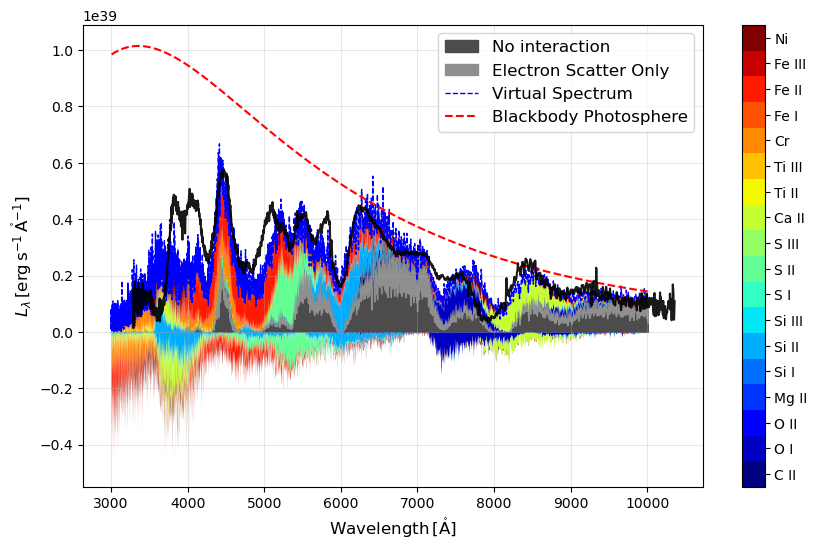

In [4]:
# Run baseline simulation
print("Running baseline simulation...")
sim_baseline = run_tardis(
    config_baseline,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

# Plot baseline comparison
plot_SDEC_with_observations(sim_baseline, spec_obs)

The simulated spectrum above differs with the observed spectrum mainly in the bluer wavelength region (3500 - 5000 $\AA$), where is dominated by the iron group elements. IGEs has large number of electrons and can influence the electron density and ionization balance in the ejecta.

Another different is the Ca II NIR triplets near 8000 $\AA$, where the feature strength and velocity is different from the observations. 

---

In TARDIS, the plasma state is solved self-consistently given temperature, hence modifying mass fraction of one element often affect the spectral features more than just that element due to the ionization balance. 

In the next part of this notebook, let's treat it as a playground of the mass fractions, modify it, run simulation and check its impact. 

---

An important information to keep in mind is that the change you seen here is not always applicable to all situations, depending on other settings, **especially the luminosity and density profiles**, the abundance effects might act differently. 


$\blacktriangleright$ Explore the affect of changing mass fraction, the cells belows shows an example of this.  

# Change Elemental Mass Fraction 

Note that TARDIS will renormalize the mass fraction if the sum is not equal to 1.

If you would like to keep the input mass fraction as the absolute value of the mass fraction for that element, you will need to manually scale the mass fraction of other elements first in the configuration before running the simulation. 

In [5]:
### choose the elements you want to change 
element_name = "Ca"
element_new_mass_fraction = 0.2

# create a copy of the baseline configuration 
config_new = deepcopy(config_baseline)

# Modify elemental abundances
config_new.model.abundances[element_name] = element_new_mass_fraction  

# run the simulation with the new configuration
# name each simulation differently so you can compare them later
sim_new = run_tardis(
    config_new,
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'851b8276-fa71-4e35-bd30-784f12ebd898': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

    'data': [{'type': 'scatter', 'uid': 'c8933854-1b15-468b-b4f0-7b79beeb03e9', …

    'data': [{'type': 'scatter', 'uid': 'c8933854-1b15-468b-b4f0-7b79beeb03e9', …

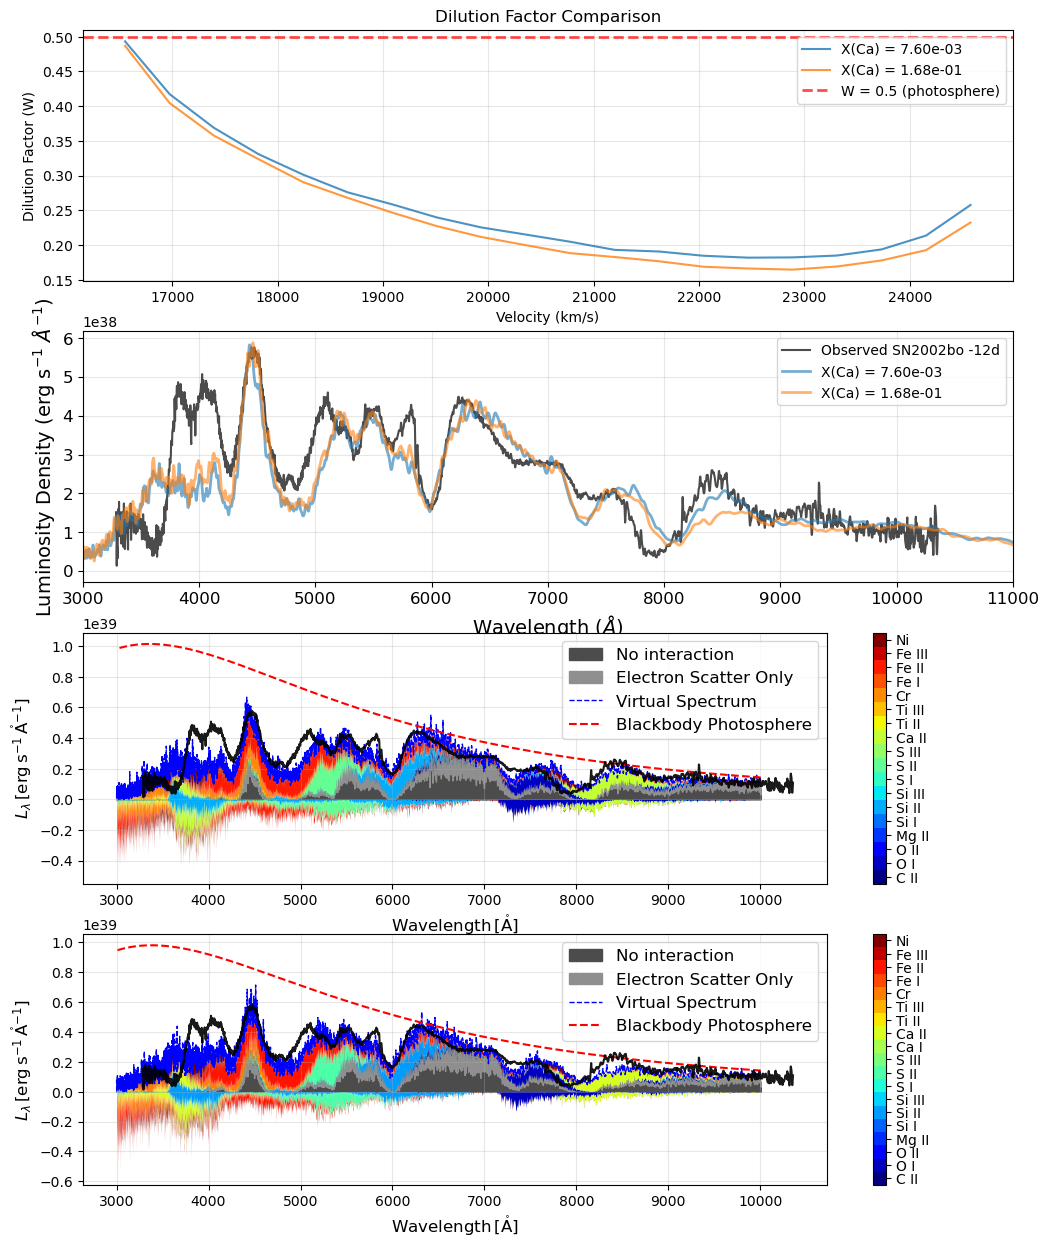

In [6]:
# compare the new simulation with the baseline
fig, axes = plt.subplots(4, 1, figsize=(12, 15))

simulations = [sim_baseline, sim_new]
element_atomic_number = element_symbol2atomic_number(element_name)
labels = [f"X({element_name}) = {sim.simulation_state.composition.elemental_mass_fraction.loc[element_atomic_number].values[0]:.2e}" for sim in simulations]

# plot the dilution factor
plot_dilution_factor(simulations, ax=axes[0], labels = labels)

# Full spectrum comparison
plot_spectral_comparison(simulations, spec_obs, ax=axes[1], labels = labels)

# SDEC plot
plot_SDEC_with_observations(sim_baseline, spec_obs, ax=axes[2])
plot_SDEC_with_observations(sim_new, spec_obs, ax=axes[3])

In [7]:
# you code here to explore other elements 


---

$\blacktriangleright$ **Reflection Questions:**
1. Which abundance modifications most improved the match with observations?
2. How do these results inform our understanding of SN2002bo's composition?
3. What additional constraints would you need for a robust abundance determination?

# Optional Exercise: Parameterized Modeling of SN2011fe

SN2011fe is one of the best-observed Type Ia supernovae, with excellent early-time spectroscopy. Your task is to create a parameterized model that matches its observed spectrum at -10 days relative to B-band maximum.

**Available Data:**
- Spectrum file: `configs_and_data/SN2011fe_2011-08-26_06-19-44_UH88_SNIFS_SNfactory.dat` from [Pereira et al. 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...554A..27P/abstract), downloaded from WISEReP. 
- Properties from the source paper: 
   - Distance: ~6.4 Mpc
   - Redshift: 0.0008
   - Bolometric luminosity: 3.6e41 erg/s at given time 
   - Time: -15 days relative to the peak light, (~2.6day since explosion)

**Your Mission:**
1. **Load and process** the SN2011fe spectrum data
2. **Start with a baseline** TARDIS configuration
3. **Systematically adjust** parameters based on spectral features:
   - Luminosity from spectrum normalization
   - v_inner from Si II 6355 absorption minimum
   - Density profile to achieve W ≈ 0.5 photospheric condition
   - Element abundances to match specific features
4. **Document your process** and justify each parameter choice
5. **Compare** your final model with observations

**Expected Deliverables:**
- Working TARDIS configuration file
- Comparison plots showing your model vs observations
- Analysis of which parameters were most important
- Discussion of remaining discrepancies and potential improvements

**No solution provided - this is your opportunity to apply everything learned!**

In [8]:
# your code here

---

Congratulations for making this far!! 

These simplified uniform abundance model though has the limitation of not covering the complex physical distribution of mass fraction, they are powerful for exploration purposes and a great start for the tomography method to rebuild the ejecta outside in (especially for modeling early time spectrum that the outer layer of the ejecta are more uniformly distributed). 

----

# Summary 

In this afternoon's notebooks, we explored a parametrized supernova ejecta model with a power-law density profile and uniform abundances, using the observed spectrum of SN 2002bo as a reference for comparison. 

The most sensitive input parameters include the bolometric luminosity, time since explosion, and the density profile, which together determine the thermodynamic structure and line-forming regions of the ejecta. 

Additionally, the elemental mass fractions strongly influence the ionization balance and excitation state of the plasma, thereby shaping the emergent spectrum in detail. 

The simulation represents a complex interplay of all these parameters, and degeneracies can arise in this high-dimensional parameter space, making it challenging to identify unique best-fit models without systematic sampling.

In [1]:
from IPython import get_ipython
from pathlib import Path
ip = get_ipython()
path = None
if '__vsc_ipynb_file__' in ip.user_ns:
    path = ip.user_ns['__vsc_ipynb_file__']
    
nb_path = Path(path)
# Get the current notebook name
current_notebook = nb_path.name

# Create the student version by replacing 'instructor' with 'student'
output_notebook = current_notebook.replace('instructor', 'student')

# Run the nbconvert command
!jupyter nbconvert {current_notebook} --ClearOutputPreprocessor.enabled=True --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['solution']" --to notebook --output {output_notebook}

print(f"Converted {current_notebook} to {output_notebook}")

/Users/jing/mambaforge/bin/jupyter-nbconvert:6: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  from nbconvert.nbconvertapp import main
[NbConvertApp] Converting notebook 4_explore_parametrized_models_part2_instructor.ipynb to notebook
[NbConvertApp] Writing 17684 bytes to 4_explore_parametrized_models_part2_student.ipynb
Converted 4_explore_parametrized_models_part2_instructor.ipynb to 4_explore_parametrized_models_part2_student.ipynb
